# 데이터 불러오기 (학습 준비 단계)

### GPU 사용 확인

만약 LogicalDevice에 GPU가 표시되지 않는다면, CUDA와 cuDNN을 설치하여 gpu가 표시되도록 준비합니다.

텐서플로우 학습을 진행할때 gpu가 아닌 cpu를 사용한다면, 학습시간이 상당히 오래 걸릴 수 있습니다.

설치방법 https://uwgdqo.tistory.com/341

In [94]:
import tensorflow as tf 
tf.config.list_logical_devices()

[LogicalDevice(name='/device:CPU:0', device_type='CPU'),
 LogicalDevice(name='/device:GPU:0', device_type='GPU')]

## 이미지 불러오기 (baseline 코드)

In [95]:
import os
import warnings
warnings.filterwarnings(action='ignore')

os.environ["CUDA_VISIBLE_DEVICES"]="0" # GPU 할당

In [96]:
#create training dataset
from glob import glob
import numpy as np
import PIL
from PIL import Image

path = './data/train/'

training_images = []
training_labels = []

for filename in glob(path +"*"):
    for img in glob(filename + "/*.jpg"):
        an_img = PIL.Image.open(img) #read img
        img_array = np.array(an_img) #img to array
        training_images.append(img_array) #append array to training_images
        label = filename.split('\\')[-1] #get label
        training_labels.append(label) #append label
        
training_images = np.array(training_images)
training_labels = np.array(training_labels)

from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
training_labels= le.fit_transform(training_labels)
training_labels = training_labels.reshape(-1,1)

print(training_images.shape)
print(training_labels.shape)

(50000, 32, 32, 3)
(50000, 1)


파일 경로를 /data/train에서 불러옵니다. (조금 시간이 걸릴 수 있습니다)

여기서 label은 image가 저장된 폴더의 이름으로 설정되며, 총 50000개의 train image가 존재하는것을 알 수 있습니다.

In [97]:
#create test dataset

path = './data/test/'

test_images = []
test_idx = []

flist = sorted(glob(path + '*.jpg'))

for filename in flist:
    an_img = PIL.Image.open(filename) #read img
    img_array = np.array(an_img) #img to array
    test_images.append(img_array) #append array to training_images 
    label = filename.split('\\')[-1] #get id 
    test_idx.append(label) #append id
    
test_images = np.array(test_images)

print(test_images.shape)
print(test_idx[0:5])

(10000, 32, 32, 3)
['0000.jpg', '0001.jpg', '0002.jpg', '0003.jpg', '0004.jpg']


파일 경로를 /data/test에서 불러옵니다. (조금 시간이 걸릴 수 있습니다)

여기서 label은 image가 저장된 폴더의 이름으로 설정되며, 총 10000개의 train image가 존재하는 것을 알 수 있습니다.

## 이미지 확인하기

training_images에는 현재 train을 위한 image가, training_labels에는 image에 해당하는 label이 저장되어 있습니다.

이와같이 test_images에도 test를 위한 image가 저장되어 있으며, 당연히 test에 해당하는 label은 우리가 추론해야 하는 값이기 때문에 주어지지 않습니다.

[0],[0],[1],[1],[2],[2],[3],[3],[4],[4],[5],[5],[6],[6],[7],[7],[8],[8],[9],[9],

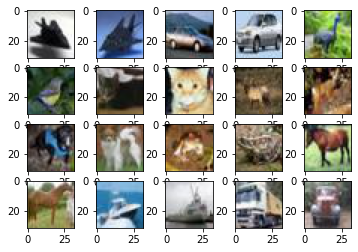

In [98]:
import matplotlib.pyplot as plt
%matplotlib inline

for i in range(20):
    plt.subplot(4, 5, i + 1)
    plt.imshow(training_images[i*2500])
    print(training_labels[i*2500], end=",")
plt.show()

10종류의 label과 image가 나타나게 된다면 데이터 불러오기 성공입니다

In [99]:
label_num = [0,1,2,3,4,5,6,7,8,9]
label_name = le.inverse_transform(label_num)

for i in range(10):
    print(label_num[i], label_name[i])

0 airplane
1 automobile
2 bird
3 cat
4 deer
5 dog
6 frog
7 horse
8 ship
9 truck


# 데이터 전처리

## data augmentation을 통한 데이터 생성

data augmentation는 data set의 개수를 늘려서 overfitting을 해결하기 위해 등장한 개념입니다.

생성된 샘플은 가능한 진짜에 가까워야 하기 때문에 data의 특성에 따라서 augmentation을 조절해주어 모델이 잘 학습할 수 있도록 해야합니다.

keras에서 제공하는 ImageDataGenerator 함수를 사용하여 데이터를 생성해 보겠습니다.

In [100]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

image_generator = ImageDataGenerator(
    rotation_range=20,
    brightness_range = [0.9, 1.0],
    zoom_range=0.3,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    vertical_flip=False
)

각각의 변수들은 다음과 같은 의미를 가집니다.

- rotation_range : 이미지를 랜덤한 각도로 돌리는 정도
- brightness_range : 이미지의 밝기를 랜덤하게 다르게 주는 정도
- zoom_range : 사진을 확대하는 정도
- width_shift_range : 사진을 왼쪽 오른쪽으로 움직이는 정도 
- height_shift_range : 사진을 위 아래로 움직이는 정도
- horizontal_flip : y축을 기준으로 반전 (오른쪽 왼쪽 뒤집기)
- vertical_flip : x축을 기준으로 반전 (위 아래 뒤집기)

여기서 저는 vertical_flip를 비활성화 했습니다. 이유는 위에 설명했듯이 생성된 샘플은 가능한 진짜에 가까워야 하기 때문입니다. 예를 들어 우리가 자동차라는 데이터를 위아래로 뒤집을 경우, 바퀴가 위로간 뒤집힌 자동차의 이미지가 생성됩니다. 이런 이미지를 학습하게 되면 변별력이 증가할 수는 있지만 일반적인 자동차의 판단에 좋지않은 영향을 끼치게 될 것 같아서 제외하였습니다.

### data augmentation 살펴보기

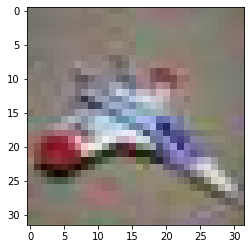

In [101]:
sample_image = training_images[1]
plt.imshow(sample_image.astype('uint8'))
sample_image = np.expand_dims(sample_image, 0)

In [102]:
sample_image_it = image_generator.flow(sample_image, batch_size=1)

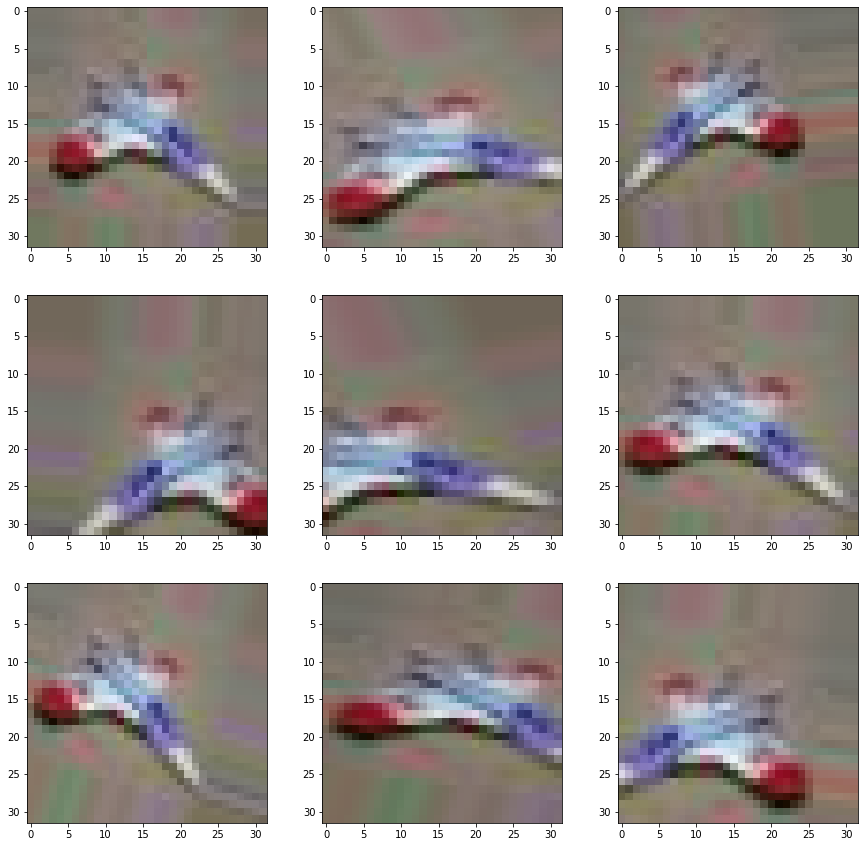

In [103]:
fig = plt.figure(figsize = (15,15))
for i in range(9):
    plt.subplot(3, 3, 1+i)
    batch = sample_image_it.next()
    image = batch[0].astype('uint8')
    plt.imshow(image)
plt.show()

### 잘 작동하는 것을 확인했으니 이제는 우리가 사용할 데이터에 augmentation을 적용해 봅시다.

In [104]:
augment_size=250000

random_mask = np.random.randint(training_images.shape[0], size=augment_size)
training_image_aug = training_images[random_mask].copy()
training_labels_aug = training_labels[random_mask].copy()

저는 25만개의 데이터를 추가로 생성하도록 하겠습니다.

In [105]:
training_image_aug = image_generator.flow(training_image_aug, np.zeros(augment_size), batch_size=augment_size, shuffle=False).next()[0]

training_images = np.concatenate((training_images, training_image_aug))
training_labels = np.concatenate((training_labels, training_labels_aug))

In [106]:
print(training_images.shape)
print(training_labels.shape)

(300000, 32, 32, 3)
(300000, 1)


data augmentation을 통해서 5만개였던 train data가 5만개에서 총 30만개로 증가한 모습입니다.

### Data set 나누기

In [107]:
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(training_images, training_labels, test_size=0.2, stratify = training_labels, random_state=1809)

X_test = test_images

train set과, validation set으로 데이터를 나눠줍니다. **여기서 저는 stratify를 추가하여 각각의 label이 골고루 분포되도록 설정하였습니다.**

stratify를 추가할 경우, train set과 validation set은 데이터를 나눠주기 이전처럼 각 label마다 10%의 이상적인 데이터 비율을 유지할 수 있습니다.

만약 stratify를 추가하지 않을 경우, 어떤 label은 18%로 많이 차지하고, 어떤 label은 2%로 적게 차지하여 샘플링 편향이 발생할 수 있습니다. 

우리가 지금 사용하는 데이터를 예시로 들어 쉽게 설명하자면, 비행기에 대한 데이터가 90%, 새에 대한 데이터가 10%의 양으로 들어있다면, 새에 대한 학습이 비행기보다 많이 이루어지지 않아서 새를 비행기로 착각하는 현상이 더욱 심하게 발생할 수 있습니다.

In [108]:
print('X_train 크기:',X_train.shape)
print('X_valid 크기:',X_valid.shape)
print('X_test  크기:',X_test.shape)

X_train 크기: (240000, 32, 32, 3)
X_valid 크기: (60000, 32, 32, 3)
X_test  크기: (10000, 32, 32, 3)


In [109]:
X_train = X_train / 255.0
X_valid = X_valid / 255.0
X_test = X_test / 255.0

[0, 255] 사이의 값을 갖는 경우 255로 나눠 [0, 1] 사이의 값으로 바꿀 수 있습니다.

[0, 1]의 값으로 변환하면 나중에 Sigmoid 함수의 출력과 비교할 수 있습니다.

입력의 범위(dynamic range)가 너무 넓은 것은 훈련이 안 되는 원인으로 작용할 수 있기 때문에 꼭 0~1 사이로 맞춰줍니다.

# 모델 생성하기

모델 생성은 매우 중요한 부분입니다. 다양한 경진대회에서 승리한 유명한 모델을 구현해볼 수도 있고, 최신 논문에 구현된 기법들을 가져와 적용해볼 수도 있습니다.

현재는 resnet, efficientnet 등 유명한 모델을 구현하여 사용하지 않고 단순한 커스텀 CNN 모델을 구현해보았습니다.

모델의 깊이와 성능은 어느정도 양의 상관관계에 있기 때문에 과적합과 gradient vanishing을 견제하면서 커스텀 모델을 깊게 짜보려고 합니다.

추후 커스텀 모델의 성능이 어느정도 진척도가 나지 않았을때, 논문에 나온 모델들 혹은 모듈을 구현해보며 단순 CNN 커스텀 모델과 성능 차이를 비교해보려고 합니다.

이처럼 모델의 층을 더 쌓아보고, 수정해보면서 데이터에 적합한 모델을 찾아나가는 과정이 필요합니다.

In [110]:
import tensorflow as tf


model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', padding='SAME',input_shape=(32, 32, 3)), #cnn layer
    tf.keras.layers.BatchNormalization(), #batch norm layer
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', padding='SAME',input_shape=(32, 32, 3)), #cnn layer
    tf.keras.layers.BatchNormalization(), #batch norm layer
    tf.keras.layers.MaxPooling2D(2, 2, padding='SAME'), #pooling layer
    
    tf.keras.layers.Conv2D(128, (3,3), activation='relu', padding='SAME',input_shape=(32, 32, 3)), #cnn layer
    tf.keras.layers.BatchNormalization(), #batch norm layer
    tf.keras.layers.Conv2D(128, (3,3), activation='relu', padding='SAME',input_shape=(32, 32, 3)), #cnn layer
    tf.keras.layers.BatchNormalization(), #batch norm layer
    tf.keras.layers.MaxPooling2D(2, 2, padding='SAME'), #pooling layer
    
    tf.keras.layers.Conv2D(256, (3,3), activation='relu', padding='SAME',input_shape=(32, 32, 3)), #cnn layer
    tf.keras.layers.BatchNormalization(), #batch norm layer
    tf.keras.layers.Conv2D(256, (3,3), activation='relu', padding='SAME',input_shape=(32, 32, 3)), #cnn layer
    tf.keras.layers.BatchNormalization(), #batch norm layer
    tf.keras.layers.MaxPooling2D(2, 2, padding='SAME'), #pooling layer
    
    tf.keras.layers.Conv2D(512, (3,3), activation='relu', padding='SAME',input_shape=(32, 32, 3)), #cnn layer
    tf.keras.layers.BatchNormalization(), #batch norm layer
    tf.keras.layers.Conv2D(512, (3,3), activation='relu', padding='SAME',input_shape=(32, 32, 3)), #cnn layer
    tf.keras.layers.BatchNormalization(), #batch norm layer
    tf.keras.layers.MaxPooling2D(2, 2, padding='SAME'), #pooling layer
    
    tf.keras.layers.GlobalAveragePooling2D(), #pooling layer
    #tf.keras.layers.Flatten(),

    tf.keras.layers.Dense(256, activation = 'relu'), #fully connected layer
    tf.keras.layers.Dropout(0.6),
    tf.keras.layers.Dense(10, activation = 'softmax') # ouput layer
])

**batch normalization**을 사용하면 regularization 효과가 있기 때문에 dropout 효과는 맨 마지막에만 사용하였으며, conv 연산 이후에 항상 추가하여 gradient의 vanishing 혹은 exploding을 방지하고 local minima에 빠지지 않도록 하였습니다.

Flatten 대신 **GlobalAveragePooling2D**을 사용하여 feature map을 벡터화시켜주고 fc layer 중간에 dropout을 껴서 regularization을 통해 과적합을 방지하였습니다. (resnet에서부터 global average pooling을 사용했다고 하네요)

### 초보분들을 위한 layer들의 자세한 설명 및 사용법은 추후에 추가해 보겠습니다.

#### tf.keras.layers.MaxPooling2D(2, 2, padding='SAME')

여기서 2, 2의 값이 의미하는 것은 2 by 2 matrix로 2 by 2 pixel을 1pixel로 크기와 특성을 뽑아 축소하겠다는 말입니다.

지금 우리가 사용하는 image는 32 by 32 의 이미지인데, 이를 2 by 2로 pooling 할 경우 16 by 16으로 줄어들게 됩니다.

이렇게 데이터를 줄이게 되면 학습 시간을 단축하고, 오버피팅을 완화할 수 있다고 합니다.

여기서는 이미지 사이즈가 그렇게 크지 않기 때문에 2 by 2 이상으로 pooling하는것은 데이터 손실로 이어질 가능성이 높다고 생각하여 모두 2 by 2로 진행하였습니다.

#### tf.keras.layers.BatchNormalization()

batch normalization을 진행합니다. 특별하게 추가해야 되는 인수는 없습니다.


작성중...

In [111]:
model.compile(optimizer='adam', loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])

In [112]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_20 (Conv2D)           (None, 32, 32, 64)        1792      
_________________________________________________________________
batch_normalization_20 (Batc (None, 32, 32, 64)        256       
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 32, 32, 64)        36928     
_________________________________________________________________
batch_normalization_21 (Batc (None, 32, 32, 64)        256       
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 16, 16, 128)       73856     
_________________________________________________________________
batch_normalization_22 (Batc (None, 16, 16, 128)      

total param이 더욱 많을수록, 학습 시간이 오래 걸리며 복잡한 모델을 의미합니다.

# 모델 학습하기

### batch size와 epoch을 조절하여 적절한 학습을 합니다. 

여기서 batch_size를 16, 32 등 2의 n제곱으로 만드는 이유는 컴퓨터의 연산을 고려하기 때문입니다.

In [113]:
data = model.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs=25, batch_size=128)

Epoch 1/25
1875/1875 [==============================] - 143s 64ms/step - loss: 1.2282 - accuracy: 0.5749 - val_loss: 0.9167 - val_accuracy: 0.6856
Epoch 2/25
1875/1875 [==============================] - 117s 62ms/step - loss: 0.7267 - accuracy: 0.7577 - val_loss: 0.7822 - val_accuracy: 0.7333
Epoch 3/25
1875/1875 [==============================] - 116s 62ms/step - loss: 0.5382 - accuracy: 0.8205 - val_loss: 0.5362 - val_accuracy: 0.8154
Epoch 4/25
1875/1875 [==============================] - 116s 62ms/step - loss: 0.4100 - accuracy: 0.8626 - val_loss: 0.5801 - val_accuracy: 0.8104
Epoch 5/25
1875/1875 [==============================] - 118s 63ms/step - loss: 0.3103 - accuracy: 0.8951 - val_loss: 0.5068 - val_accuracy: 0.8386
Epoch 6/25
1875/1875 [==============================] - 119s 64ms/step - loss: 0.2366 - accuracy: 0.9200 - val_loss: 0.4959 - val_accuracy: 0.8459
Epoch 7/25
1875/1875 [==============================] - 116s 62ms/step - loss: 0.1821 - accuracy: 0.9379 - val_loss: 0

### 학습된 그래프를 보고 overfitting, underfitting의 여부를 확인합니다.

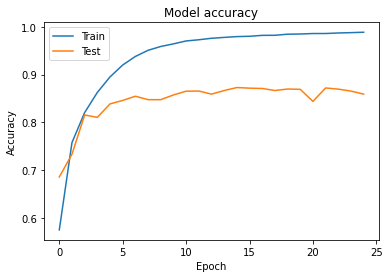

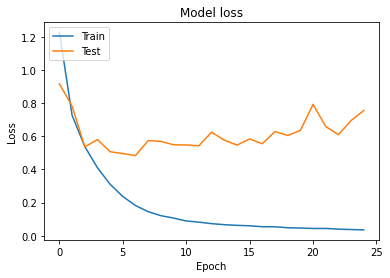

In [115]:
import matplotlib.pyplot as plot

plot.plot(data.history['accuracy'])
plot.plot(data.history['val_accuracy'])
plot.title('Model accuracy')
plot.ylabel('Accuracy')
plot.xlabel('Epoch')
plot.legend(['Train', 'Test'], loc='upper left')
plot.show()

plot.plot(data.history['loss'])
plot.plot(data.history['val_loss'])
plot.title('Model loss')
plot.ylabel('Loss')
plot.xlabel('Epoch')
plot.legend(['Train', 'Test'], loc='upper left')
plot.show()

# 제출하기

학습된 모델을 이용하여 제출합니다

In [116]:
pred_proba = model.predict(X_test) 

pred_class = []

for i in pred_proba:
    pred = np.argmax(i)
    pred_class.append(pred)
    
pred_class = le.inverse_transform(pred_class)
pred_class[0:5]

array(['horse', 'airplane', 'airplane', 'horse', 'bird'], dtype='<U10')

In [117]:
import pandas as pd

sample_submission = pd.read_csv("./data/sample_submission.csv")

sample_submission.target = pred_class
sample_submission.to_csv("submit_3.csv",index=False)

In [118]:
sample_submission.head(10)

,id,target
0,0000.jpg,horse
1,0001.jpg,airplane
2,0002.jpg,airplane
3,0003.jpg,horse
4,0004.jpg,bird
5,0005.jpg,deer
6,0006.jpg,airplane
7,0007.jpg,deer
8,0008.jpg,airplane
9,0009.jpg,deer
